In [16]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import nltk
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

In [4]:
abc = pd.read_csv("/content/abcnews-date-text.csv")
#or
# data = pd.read_csv(abc, parse_dates=[0], infer_datetime_format=True)

In [39]:
abc.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [5]:
abc.shape

(1244184, 2)

In [6]:
abc.isnull().sum()

,0
publish_date,0
headline_text,0


In [7]:
abc.duplicated().sum()

np.int64(2)

In [8]:
abc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244184 entries, 0 to 1244183
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   publish_date   1244184 non-null  int64 
 1   headline_text  1244184 non-null  object
dtypes: int64(1), object(1)
memory usage: 19.0+ MB


In [10]:
# Convert date to datetime format
abc['publish_date'] = pd.to_datetime(abc['publish_date'], format='%Y%m%d')

In [11]:
abc.head(1)

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...


In [12]:
# First we develop a list of the top words used across all one million headlines, giving us a glimpse into the core vocabulary of the source data.
# Stop words are omitted here to avoid any trivial conjunctions, prepositions, etc.

# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)

    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [13]:
reindexed_data = abc['headline_text']

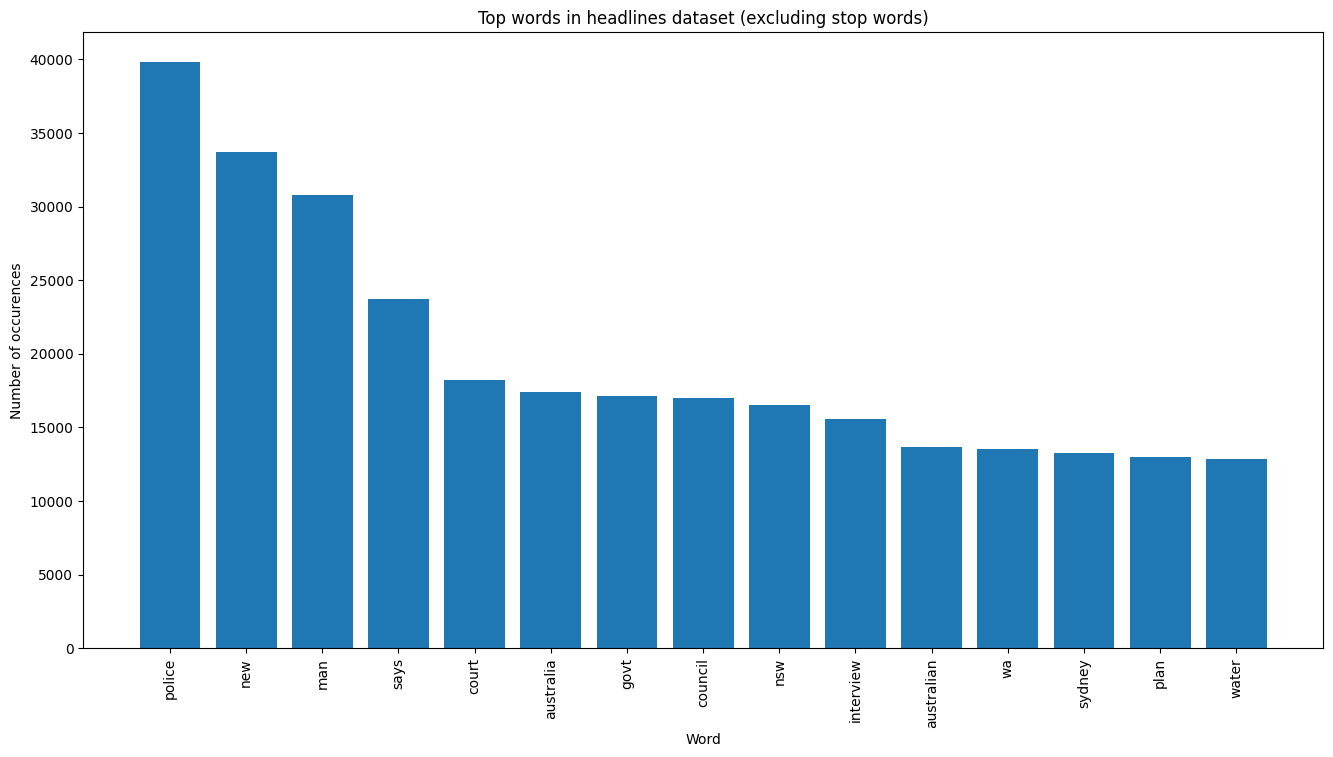

In [14]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer,
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [18]:
#Next we generate a histogram of headline word lengths, and use part-of-speech tagging to understand the types of words used across the corpus.
#This requires first converting all headline strings to TextBlobs and calling the pos_tags method on each, yielding a list of tagged words for each headline
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

tagged_headlines = [TextBlob(reindexed_data[i]).pos_tags for i in range(reindexed_data.shape[0])]

tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = []
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1

print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Total number of words:  8166553
Mean number of words per headline:  6.563782366595294


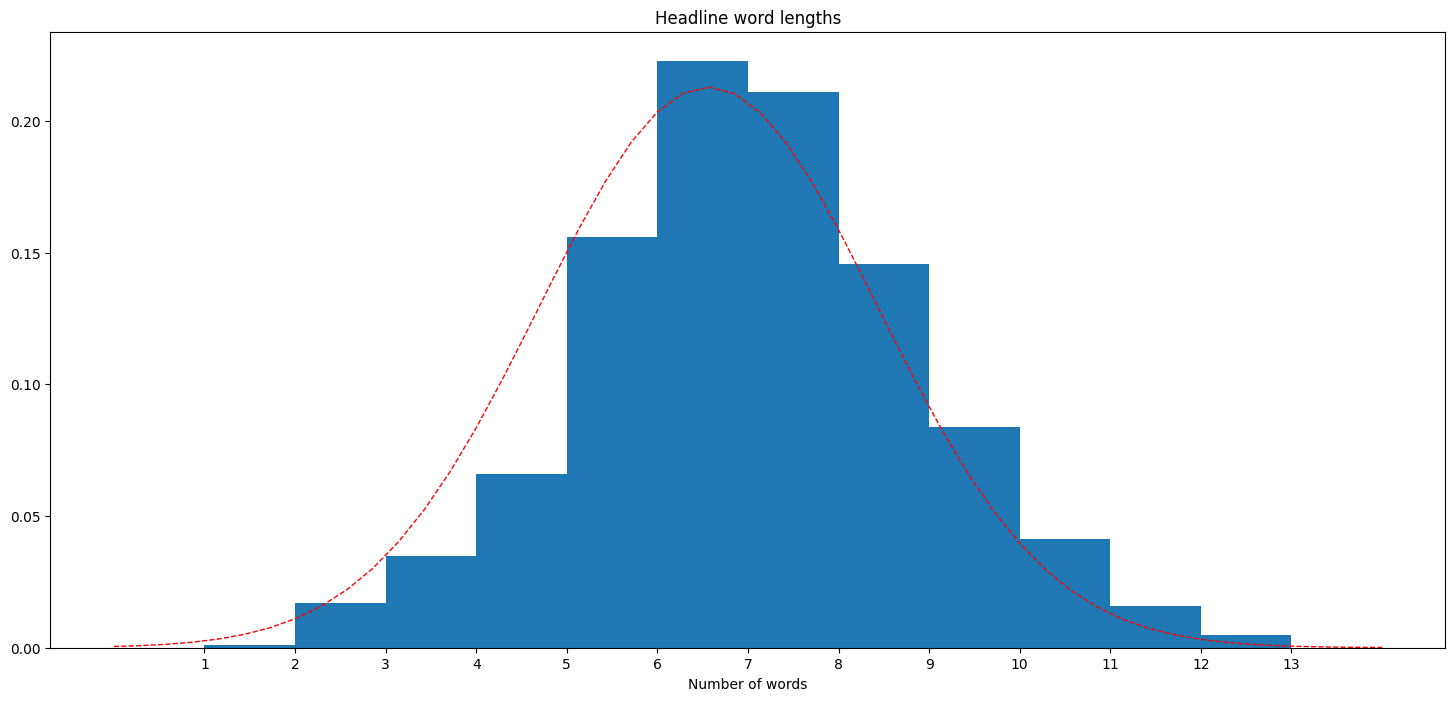

In [19]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1);
ax.set_title('Headline word lengths');
ax.set_xticks(range(1,14));
ax.set_xlabel('Number of words');
plt.show()

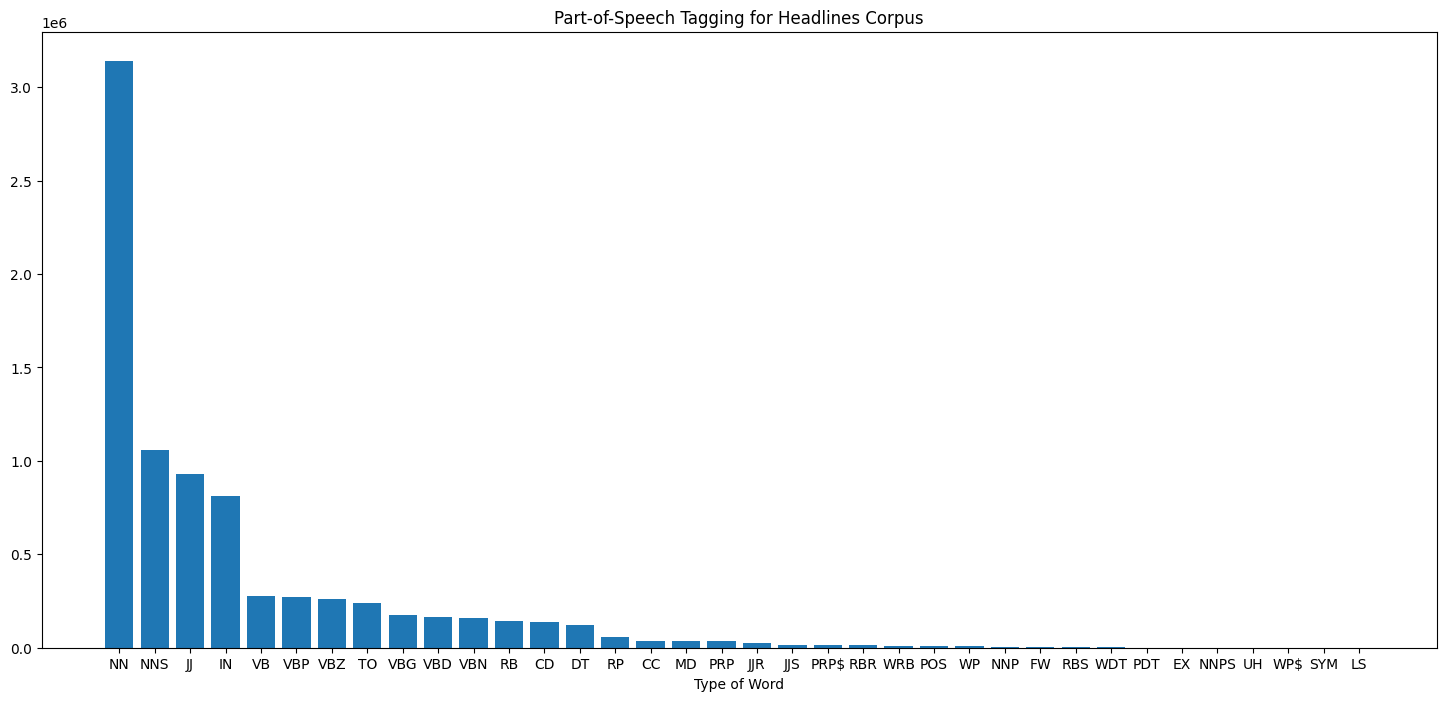

In [20]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for Headlines Corpus');
ax.set_xlabel('Type of Word');

Topic Modelling

We now apply a clustering algorithm to the headlines corpus in order to study the topic focus of ABC News, as well as how it has evolved through time. To do so, we first experiment with a small subsample of the dataset in order to determine which of the two potential clustering algorithms is most appropriate – once this has been ascertained, we then scale up to a larger portion of the available data.

# Preprocessing

In [24]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')


# Basic preprocessing functions
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove special chars/numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and short tokens, lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens
              if token not in stop_words and len(token) > 3]
    return tokens

# Apply preprocessing
abc['processed'] = abc['headline_text'].apply(preprocess)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert tokens back to string for vectorizer
abc['processed_text'] = abc['processed'].apply(' '.join)

# Create TF-IDF matrix
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, max_features=10000)
tfidf_matrix = tfidf.fit_transform(abc['processed_text'])

In [27]:
from sklearn.decomposition import TruncatedSVD

# Set number of topics
n_topics = 10

# Create LSA model
lsa = TruncatedSVD(n_components=n_topics, random_state=42)
lsa_matrix = lsa.fit_transform(tfidf_matrix)

# Get top words for each topic
terms = tfidf.get_feature_names_out()

def get_top_terms(model, terms, n_terms):
    top_terms = []
    for idx, topic in enumerate(model.components_):
        top_terms.append([terms[i] for i in topic.argsort()[:-n_terms-1:-1]])
    return top_terms

lsa_top_terms = get_top_terms(lsa, terms, 10)

# Display LSA topics
for i, terms in enumerate(lsa_top_terms):
    print(f"LSA Topic {i}: {', '.join(terms)}")

LSA Topic 0: police, crash, death, court, woman, fire, murder, charged, missing, call
LSA Topic 1: interview, extended, michael, john, david, james, smith, andrew, matt, scott
LSA Topic 2: police, investigate, search, probe, officer, missing, hunt, arrest, interview, shooting
LSA Topic 3: court, face, murder, charged, charge, accused, death, crash, woman, front
LSA Topic 4: rural, news, national, market, court, business, murder, death, analysis, face
LSA Topic 5: fire, crash, dy, killed, house, fatal, road, charged, plane, death
LSA Topic 6: fire, court, house, face, govt, police, plan, charge, home, accused
LSA Topic 7: australia, market, fire, south, call, world, country, report, hour, coronavirus
LSA Topic 8: call, court, crash, face, govt, change, health, rural, medium, government
LSA Topic 9: country, hour, call, death, health, road, august, crash, october, september


In [29]:
from sklearn.decomposition import LatentDirichletAllocation

# Convert to term frequency matrix (LDA works better with counts)
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(max_df=0.95, min_df=2, max_features=10000)
count_matrix = count.fit_transform(abc['processed_text'])

# Create LDA model
lda = LatentDirichletAllocation(n_components=n_topics,
                              random_state=42,
                              learning_method='online',
                              batch_size=128,
                              n_jobs=-1)

lda_matrix = lda.fit_transform(count_matrix)

# Get top words for LDA
lda_terms = count.get_feature_names_out()
lda_top_terms = get_top_terms(lda, lda_terms, 10)

# Display LDA topics
for i, terms in enumerate(lda_top_terms):
    print(f"LDA Topic {i}: {', '.join(terms)}")

LDA Topic 0: australian, trump, adelaide, final, drug, make, driver, federal, mine, protest
LDA Topic 1: crash, south, market, death, hospital, canberra, house, brisbane, win, road
LDA Topic 2: fire, woman, plan, change, news, farmer, dy, perth, former, missing
LDA Topic 3: police, australia, sydney, health, report, charged, open, rural, family, could
LDA Topic 4: queensland, back, minister, accused, time, killed, student, fall, push, hope
LDA Topic 5: government, child, melbourne, record, state, help, show, return, govt, resident
LDA Topic 6: say, world, attack, found, north, country, business, tasmania, donald, west
LDA Topic 7: election, home, coast, take, test, worker, gold, community, people, fight
LDA Topic 8: coronavirus, call, court, covid, case, murder, first, face, trial, charge
LDA Topic 9: year, interview, china, school, victoria, national, rise, high, centre, leader
